In [3]:
product_feature_path = "data/df_product_features.csv"


In [16]:
import pandas as pd
import json


df_data = pd.read_csv(product_feature_path)
print(
    "Total records number:", len(df_data)
)
print('-' * 120)


print(
    "data preview:\n",
    df_data.head(5).to_string()
)





Total records number: 84
------------------------------------------------------------------------------------------------------------------------
data preview:
      Product Spec   P4080_value  P4080_lb  P4080_ub  P4080_Wgt_wto_liner_target_value P4433_value  P4433_lb  P4433_ub  P4433_Ttl_thick_wto_liner_10n_target_value   P4079_value  P4079_lb  P4079_ub  P4079_Wgt_after_1st_coating_wto_liner_target_value P4005_value  P4005_lb  P4005_ub  P4005_PA_Steel_open_target_value P4006_value  P4006_lb  P4006_ub  P4006_PA_Steel_cover_target_value P4007_value  P4007_lb  P4007_ub  P4007_PA_Steel_14d_open_target_value P4008_value  P4008_lb  P4008_ub  P4008_PA_Steel_14d_cover_target_value P4004_value  P4004_lb  P4004_ub  P4004__target_value P4041_value  P4041_lb  P4041_ub  P4041_HP_Steel_open_target_value P4013_value  P4013_lb  P4013_ub  P4013_PA_PC_target_value P4338_value  P4338_lb  P4338_ub  P4338_PA_steel_inside_target_value P4339_value  P4339_lb  P4339_ub  P4339_PA_steel_outside_target_value P43

In [18]:
df_item_no = pd.read_csv("data/item_no_name_mapping.csv", sep="|")


print(
    "item no mapping preview:\n",
    df_item_no.head().to_string()
)


item no mapping preview:
   Item No.  product count                                 Item Description
0    P4080             42                      Total weight, without liner
1    P4433             42   Total thickness, without liner (10N;disc:16mm)
2    P4079             41    Total weight after 1st coating, without liner
3    P4005             32     Peel adhesion/Steel, open side (180° method)
4    P4006             32  Peel adhesion/Steel, covered side (180° method)


# Data analysis

In [19]:
def calculate_feature_metrics(df: pd.DataFrame, target_value_col: str) -> pd.DataFrame:
    """
    为每个feature column （名字包含feature_） 计算missing rate， mean， min， max， 25%， 50%， 75%， 95%，
    将这些metric 作为column，把每个feature column的metric结果拼接成一个dataframe 返回

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame with metrics for each feature column.
    """
    metrics_list = []
    feature_cols = [col for col in df.columns if col.startswith("feature_")]

    for col in feature_cols + [target_value_col]:
        if df[col].isnull().all():
            metrics = {
                "property_name": col,
                "total_cnt": len(df),
                "missing_cnt": len(df),
                "missing_rate": 1.0,
                "mean": None,
                "min": None,
                "P25": None,
                "P50": None,
                "P75": None,
                "P95": None,
                "max": None,
                "corr": None,
                "var": None,
            }
        else:
            quantiles = df[col].quantile([0.25, 0.5, 0.75, 0.95])
            if col != target_value_col:
                corr = df[[target_value_col, col]].corr(method='pearson').loc[target_value_col, col]
            else:
                corr = 1.0
            # 计算方差
            var = df[col].var()
            metrics = {
                "property_name": col,
                "total_cnt": len(df),
                "missing_cnt": df[col].isnull().sum(),
                "missing_rate": df[col].isnull().mean(),
                "mean": df[col].mean(),
                "min": df[col].min(),
                "P25": quantiles[0.25],
                "P50": quantiles[0.50],
                "P75": quantiles[0.75],
                "P95": quantiles[0.95],
                "max": df[col].max(),
                "var": var,
                "corr": corr,
            }
        metrics_list.append(metrics)

    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df




# 全部产品

In [20]:
target_col ="P4006_PA_Steel_cover_target_value"
stats = calculate_feature_metrics(df_data, target_value_col=target_col)

feature_columns = stats[
    stats["missing_rate"] < 0.3
]["property_name"].tolist()

print("\n".join(sorted(feature_columns)))

P4006_PA_Steel_cover_target_value
feature_adhesive ## holding power (mins) ## rt
feature_adhesive ## peel adhesion (n/cm) ## sus
feature_adhesive ## tg(℃) ## dma
feature_adhesive ## tg(℃) ## dsc
feature_backing ## elongation at break cd
feature_backing ## elongation at break md
feature_backing ## shrinkage md
feature_backing ## tensile strength cd
feature_backing ## tensile strength md
feature_backing ## thickness
feature_backing ## weight per unit area
feature_liner ## thickness ## µm


In [24]:
stats[
    stats["property_name"].isin(feature_columns)
][["property_name", "missing_rate",  "missing_cnt", "corr",]]

,property_name,missing_rate,missing_cnt,corr
5,feature_adhesive ## holding power (mins) ## rt,0.250000,21,NaN
13,feature_adhesive ## peel adhesion (n/cm) ## sus,0.202381,17,0.692115
16,feature_adhesive ## tg(℃) ## dma,0.297619,25,0.775705
17,feature_adhesive ## tg(℃) ## dsc,0.250000,21,-0.656760
21,feature_backing ## elongation at break cd,0.297619,25,-0.190214
22,feature_backing ## elongation at break md,0.226190,19,-0.185781
25,feature_backing ## shrinkage md,0.226190,19,0.111216
28,feature_backing ## tensile strength cd,0.297619,25,-0.373730
29,feature_backing ## tensile strength md,0.226190,19,-0.364102
31,feature_backing ## thickness,0.226190,19,-0.392950


# 按照L1 L2 产品标签进行分析

In [284]:
# select by product label

df_data.groupby(["L1", "L2"], dropna=False).size().reset_index(name='counts').sort_values(by=["counts"], ascending=False)




,L1,L2,counts
0,Anti-repulsion,General mounting,20
1,Anti-repulsion,High cohesion,12
2,Differential,Removable,12
6,NaN,NaN,9
3,High PA,Anti-repulsion,4
5,Removable,Differential,4
4,High cohesion,Anti-repulsion,2


In [285]:
df_data["L1"].value_counts(dropna=False)

L1
Anti-repulsion    32
Differential      12
NaN                9
Removable          4
High PA            4
High cohesion      2
Name: count, dtype: int64

In [286]:
df_data["L2"].value_counts(dropna=False)

L2
General mounting    20
Removable           12
High cohesion       12
NaN                  9
Anti-repulsion       6
Differential         4
Name: count, dtype: int64

In [287]:
# Anti-repulsion: 抗翘曲
# Differential: 双面差异
# General mounting



In [288]:
df_anti_repulsion = df_data[df_data["L1"] == "Anti-repulsion"].copy()

print(
    df_anti_repulsion.head().to_string()
)
print("-" * 120)


df_anti_stats = calculate_feature_metrics(df_anti_repulsion, target_value_col="P4005_target_value")
# 存储到excel 文件
df_anti_stats.to_excel("data/df_anti_repulsion_feature_stats.xlsx", index=False)


print(
    df_anti_stats.head().to_string()
)
print("-" * 120)




      Product Spec   Adhesive_NART      Liner_NART    Backing_NART              L1             L2   P4080_value  P4080_lb  P4080_ub  P4080_target_value   P4079_value  P4079_lb  P4079_ub  P4079_target_value P4005_value  P4005_lb  P4005_ub  P4005_target_value P4006_value  P4006_lb  P4006_ub  P4006_target_value P4007_value  P4007_lb  P4007_ub  P4007_target_value P4008_value  P4008_lb  P4008_ub  P4008_target_value P4002_value  P4002_lb  P4002_ub  P4002_target_value P4041_value  P4041_lb  P4041_ub  P4041_target_value P4013_value  P4013_lb  P4013_ub  P4013_target_value P4433_value  P4433_lb  P4433_ub  P4433_target_value  feature_adhesive ## acid free ##   feature_adhesive ## edge taping ## 60/90  feature_adhesive ## heat resistance ## 200℃ 8hrs  feature_adhesive ## holding power (mins) ## 70℃  feature_adhesive ## holding power (mins) ## rt  feature_adhesive ## micro shear ## distance µm  feature_adhesive ## name plate (mm) ## 30°,60/90 24hr  feature_adhesive ## peel adhesion (n/cm) ## astm  

In [289]:
df_general_mount = df_data[df_data["L2"] == "General mounting"].copy()

print(
    df_general_mount.head().to_string()
)
print("-" * 120)


df_general_mount_stats = calculate_feature_metrics(df_general_mount, target_value_col="P4005_target_value")
# 存储到excel 文件
df_general_mount_stats.to_excel("data/df_general_mounting_feature_stats.xlsx", index=False)


print(
    df_general_mount_stats.head().to_string()
)
print("-" * 120)



print(
    df_general_mount_stats.sort_values(by="corr", ascending=False).head(10).to_string()
)
print("-" * 120)


      Product Spec   Adhesive_NART      Liner_NART    Backing_NART              L1                L2    P4080_value  P4080_lb  P4080_ub  P4080_target_value   P4079_value  P4079_lb  P4079_ub  P4079_target_value P4005_value  P4005_lb  P4005_ub  P4005_target_value P4006_value  P4006_lb  P4006_ub  P4006_target_value P4007_value  P4007_lb  P4007_ub  P4007_target_value P4008_value  P4008_lb  P4008_ub  P4008_target_value P4002_value  P4002_lb  P4002_ub  P4002_target_value P4041_value  P4041_lb  P4041_ub  P4041_target_value P4013_value  P4013_lb  P4013_ub  P4013_target_value P4433_value  P4433_lb  P4433_ub  P4433_target_value  feature_adhesive ## acid free ##   feature_adhesive ## edge taping ## 60/90  feature_adhesive ## heat resistance ## 200℃ 8hrs  feature_adhesive ## holding power (mins) ## 70℃  feature_adhesive ## holding power (mins) ## rt  feature_adhesive ## micro shear ## distance µm  feature_adhesive ## name plate (mm) ## 30°,60/90 24hr  feature_adhesive ## peel adhesion (n/cm) ## as

In [290]:
df_anti_repulsion[["P4005_target_value", "P4006_target_value", ]].corr()

,P4005_target_value,P4006_target_value
P4005_target_value,1.000000,0.992178
P4006_target_value,0.992178,1.000000


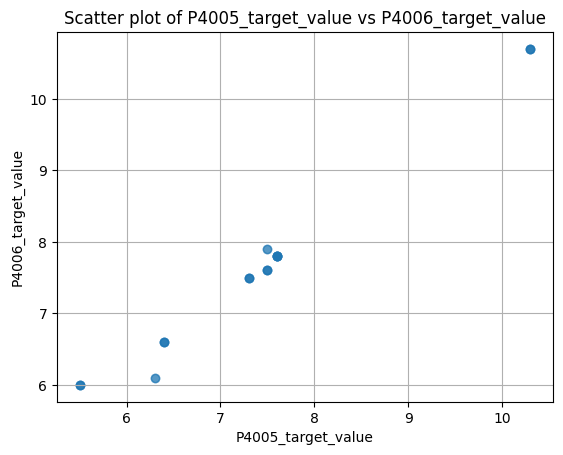

In [291]:
# 绘制P4005_target_value 和 P4006_target_value 的散点图
# L1 anti-repulsion

import matplotlib.pyplot as plt
plt.scatter(df_anti_repulsion["P4005_target_value"], df_anti_repulsion["P4006_target_value"], alpha=0.5)
plt.title("Scatter plot of P4005_target_value vs P4006_target_value")
plt.xlabel("P4005_target_value")
plt.ylabel("P4006_target_value")
plt.grid()
plt.show()


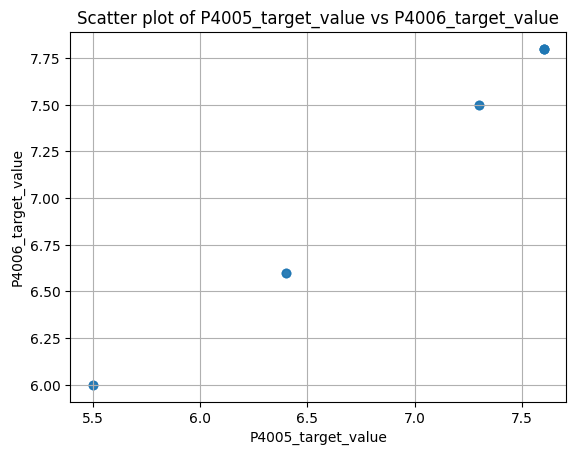

In [292]:
# 绘制P4005_target_value 和 P4006_target_value 的散点图
# L2 general mounting
import matplotlib.pyplot as plt
plt.scatter(df_general_mount["P4005_target_value"], df_general_mount["P4006_target_value"], alpha=0.5)
plt.title("Scatter plot of P4005_target_value vs P4006_target_value")
plt.xlabel("P4005_target_value")
plt.ylabel("P4006_target_value")
plt.grid()
plt.show()


# P4005 和 P4006 相关性分析

In [293]:
df_corr = df_data[
    (df_data["P4005_target_value"].notna()) 
    & (df_data["P4006_target_value"].notna())
]

df_corr[["P4005_target_value", "P4006_target_value"]].corr()




,P4005_target_value,P4006_target_value
P4005_target_value,1.000000,0.661284
P4006_target_value,0.661284,1.000000


# Anti-repulsion: correlation analysis

In [294]:
item_nos = [col.split("_")[0] for col in df_data.columns if col.endswith("_target_value")]
item_nos  = sorted(list(set(item_nos)))
print("item_nos:", item_nos)
print("-" * 120)


# anti 
df_anti_repulsion = df_data[df_data["L1"] == "Anti-repulsion"].copy()
print(
    "df anti repulsion preview:\n", 
    df_anti_repulsion.head(5).to_string()
)

item_nos: ['P4002', 'P4005', 'P4006', 'P4007', 'P4008', 'P4013', 'P4041', 'P4079', 'P4080', 'P4433']
------------------------------------------------------------------------------------------------------------------------
df anti repulsion preview:
       Product Spec   Adhesive_NART      Liner_NART    Backing_NART              L1             L2   P4080_value  P4080_lb  P4080_ub  P4080_target_value   P4079_value  P4079_lb  P4079_ub  P4079_target_value P4005_value  P4005_lb  P4005_ub  P4005_target_value P4006_value  P4006_lb  P4006_ub  P4006_target_value P4007_value  P4007_lb  P4007_ub  P4007_target_value P4008_value  P4008_lb  P4008_ub  P4008_target_value P4002_value  P4002_lb  P4002_ub  P4002_target_value P4041_value  P4041_lb  P4041_ub  P4041_target_value P4013_value  P4013_lb  P4013_ub  P4013_target_value P4433_value  P4433_lb  P4433_ub  P4433_target_value  feature_adhesive ## acid free ##   feature_adhesive ## edge taping ## 60/90  feature_adhesive ## heat resistance ## 200℃ 8hrs  

## Target level

In [295]:
# target missing rate
df_target_missing_rates = df_anti_repulsion[[f"{item_no}_target_value" for item_no in item_nos]]\
                            .isnull()\
                            .mean()\
                            .reset_index()\
                            .rename(columns={"index": "item_no", 0: "missing_rate"})


df_target_missing_rates.sort_values("missing_rate")
print(
    "Top 10 target value columns with lowest missing rates:\n",
    df_target_missing_rates.sort_values("missing_rate").head(10).to_string()
)
print("-" * 120)


focus_target_cols = df_target_missing_rates[df_target_missing_rates["missing_rate"] < 0.5]["item_no"].tolist()
print(
    "focus_target_cols:\n", 
    focus_target_cols
)

# convert data type
for col in focus_target_cols:
    df_anti_repulsion[col] = pd.to_numeric(df_anti_repulsion[col], errors='coerce')

print('-' * 120)



Top 10 target value columns with lowest missing rates:
               item_no  missing_rate
1  P4005_target_value        0.0000
2  P4006_target_value        0.0000
3  P4007_target_value        0.0000
4  P4008_target_value        0.0000
6  P4041_target_value        0.0000
7  P4079_target_value        0.0000
8  P4080_target_value        0.0000
0  P4002_target_value        0.3125
5  P4013_target_value        0.3750
9  P4433_target_value        0.6875
------------------------------------------------------------------------------------------------------------------------
focus_target_cols:
 ['P4002_target_value', 'P4005_target_value', 'P4006_target_value', 'P4007_target_value', 'P4008_target_value', 'P4013_target_value', 'P4041_target_value', 'P4079_target_value', 'P4080_target_value']
------------------------------------------------------------------------------------------------------------------------


target correlation preview:
     P4002_target_value  P4005_target_value  P4006_target_value  P4007_target_value  P4008_target_value  P4013_target_value  P4041_target_value  P4079_target_value  P4080_target_value
7                  NaN                 6.3                 6.1                 8.2                 7.8                 NaN              1440.0                21.3                36.3
8                  NaN                 6.3                 6.1                 8.2                 7.8                 NaN              1440.0                21.3                36.3
9                  NaN                 7.5                 7.6                 8.9                 8.8                 NaN              1440.0                32.3                58.3
10                 NaN                 7.5                 7.6                 8.9                 8.8                 NaN              1440.0                32.3                58.3
11                 NaN                 7.5              

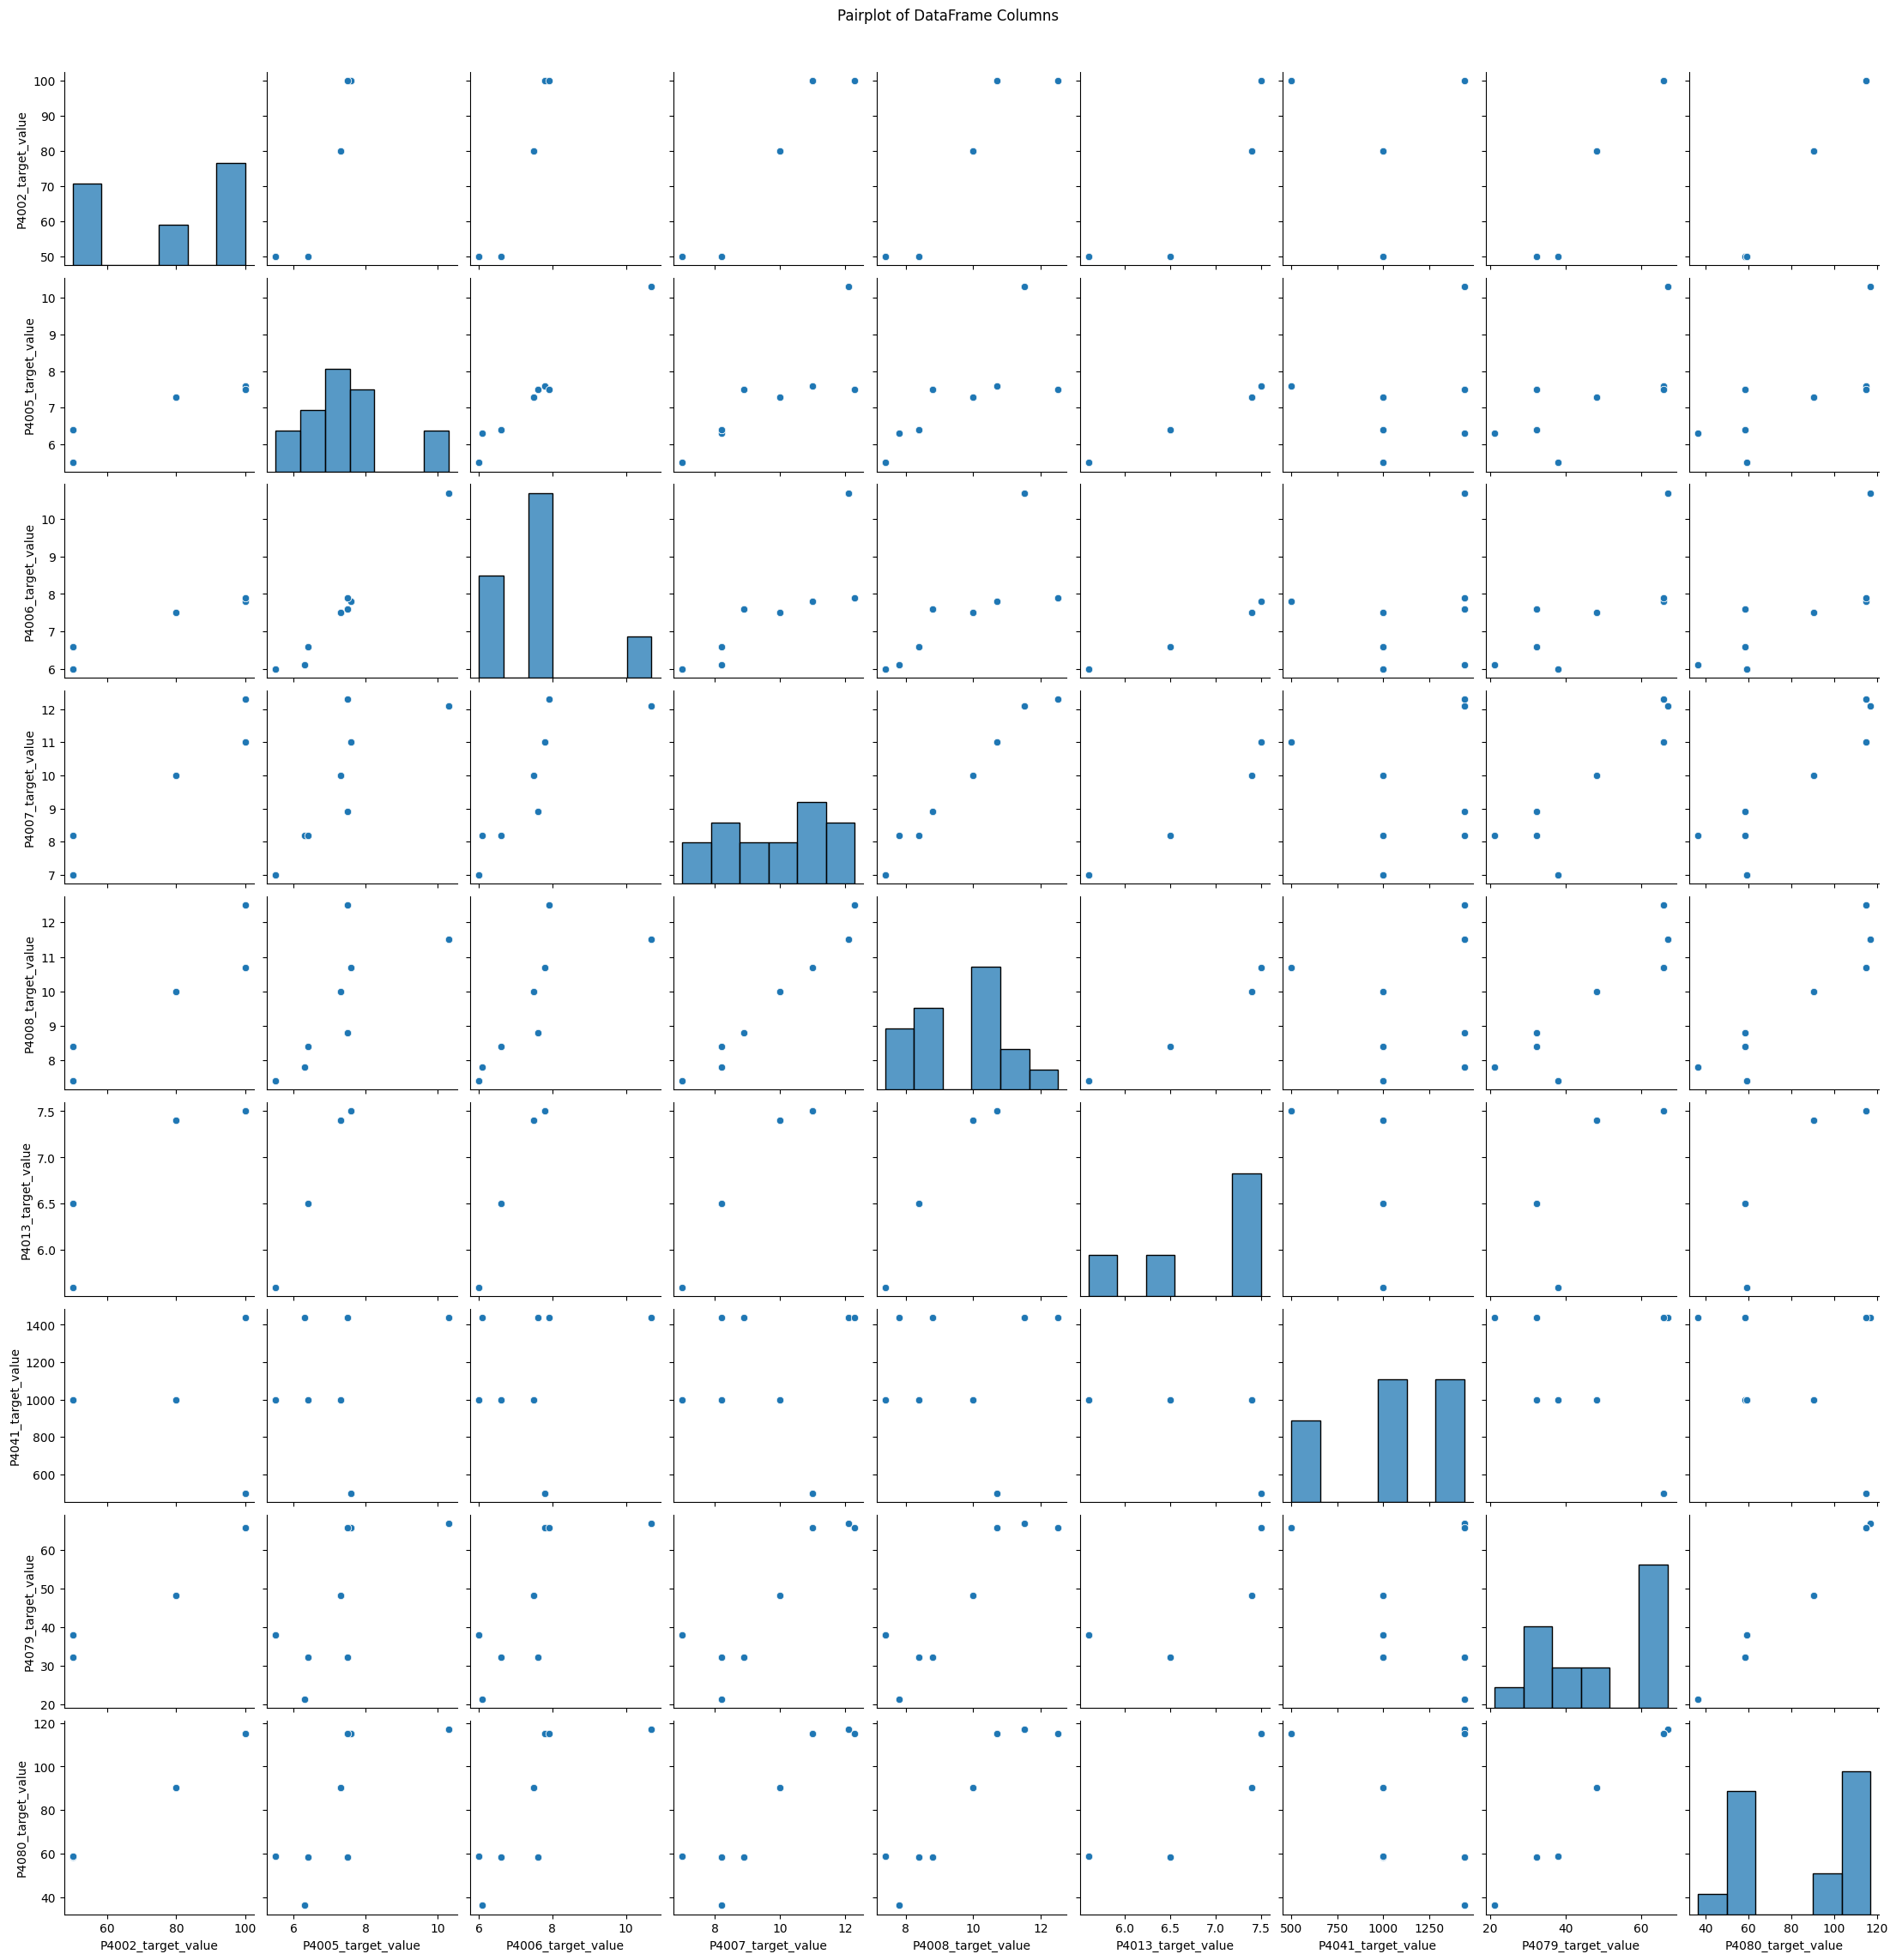

In [296]:
import seaborn as sns
import matplotlib.pyplot as plt


# corr between target value columns
df_target_corr = df_anti_repulsion[focus_target_cols].copy()
print(
    "target correlation preview:\n",
    df_target_corr.head().to_string()
)
print('-' * 120)


# corr between target value columns
# 1. 基础的 pairplot
# Seaborn 会自动识别数值列并绘制它们两两之间的关系图
sns.pairplot(df_target_corr)
plt.suptitle('Pairplot of DataFrame Columns', y=1.02) # y调整标题位置
plt.show()


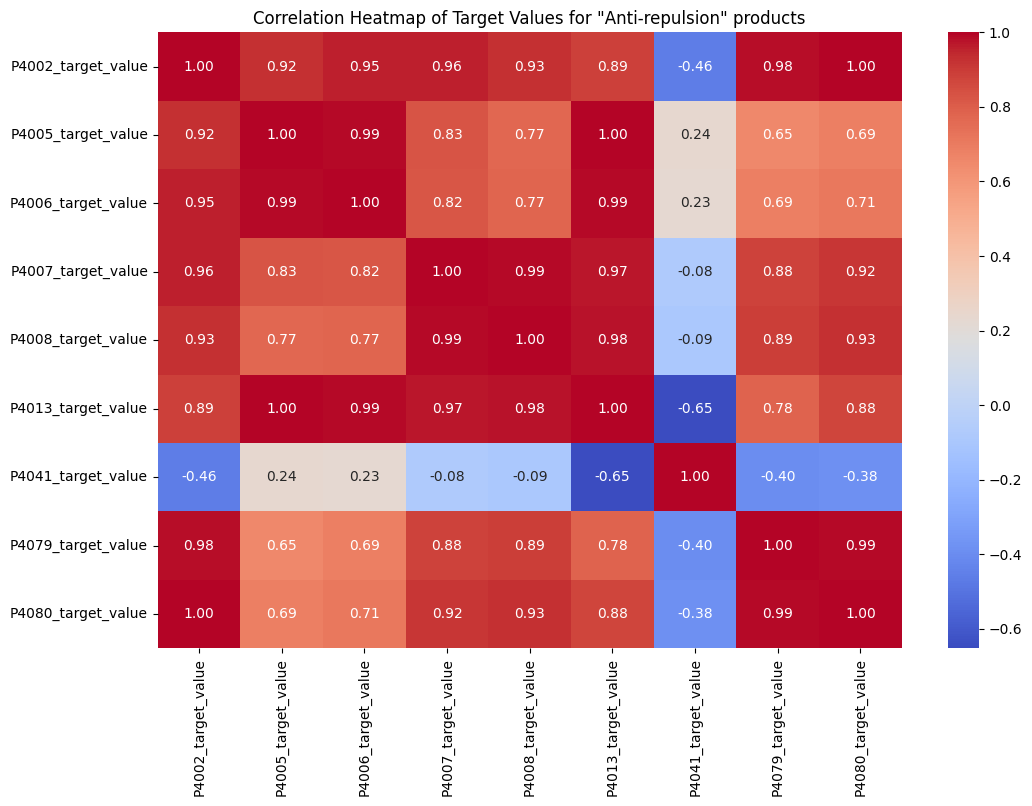

In [297]:
# Calculate the correlation matrix
corr_matrix = df_target_corr.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Target Values for "Anti-repulsion" products')
plt.show()



In [298]:
# Item No.|product count|Item Description
# P4005|32|Peel adhesion/Steel, open side (180° method)
# P4006|32|Peel adhesion/Steel, covered side (180° method)
# P4007|32|Peel adhesion/Steel, 14 days, open side (180° method)
# P4008|32|Peel adhesion/Steel, 14days, covered side (180° method)
# P4002|26|Total thickness, without liner (4,0N;disc:10mm)
# P4041|26|Holding power/steel, open side (10N;RT)
# P4013|25|Peel adhesion/PC, open side (180° method)
# P4433|16|Total thickness, without liner (10N;disc:16mm)
# P4338|4|Peel adhesion/Steel, inside (180° method, ASTM3300)
# P4339|4|Peel adhesion/Steel, outside (180° method, ASTM3300)
# P4342|4|Peel adhesion/ASTM-Steel, open side (180° method)
# P4343|4|Peel adhesion/ASTM-Steel, covered side (180° method)


## Feature level

In [299]:
# calculate missing rate for each feature column
df_feature_missing_rates = []
feature_cols = [col for col in df_anti_repulsion.columns if col.startswith("feature_")]
for col in feature_cols:
    missing_rate = df_anti_repulsion[col].isnull().mean()
    df_feature_missing_rates.append({"feature_col": col, "missing_rate": missing_rate})
df_feature_missing_rates = pd.DataFrame(df_feature_missing_rates)


# filter feature columns with missing rate
focus_feature_cols = df_feature_missing_rates[df_feature_missing_rates["missing_rate"] < 0.5]["feature_col"].tolist()
print(
    "total focus feature cols:", len(focus_feature_cols)
)
print("-" * 120)

# convert data type
for col in focus_feature_cols:
    df_anti_repulsion[col] = pd.to_numeric(df_anti_repulsion[col], errors='coerce')



total focus feature cols: 28
------------------------------------------------------------------------------------------------------------------------


feature-target correlation preview:
                                                       P4002_target_value P4005_target_value P4006_target_value P4007_target_value P4008_target_value P4013_target_value P4041_target_value P4079_target_value P4080_target_value
feature_adhesive ## edge taping ## 60/90                        0.306786           0.500138           0.466287           0.273989           0.223957                NaN           0.847998          -0.073646          -0.065325
feature_adhesive ## holding power (mins) ## rt                       NaN                NaN                NaN                NaN                NaN                NaN                NaN                NaN                NaN
feature_adhesive ## name plate (mm) ## 30°,60/90 24hr          -0.306786           0.311252            0.25798          -0.190452           -0.32069                NaN           0.282666          -0.316349          -0.304006
feature_adhesive ## peel adhesion (n/cm) ## pc                 

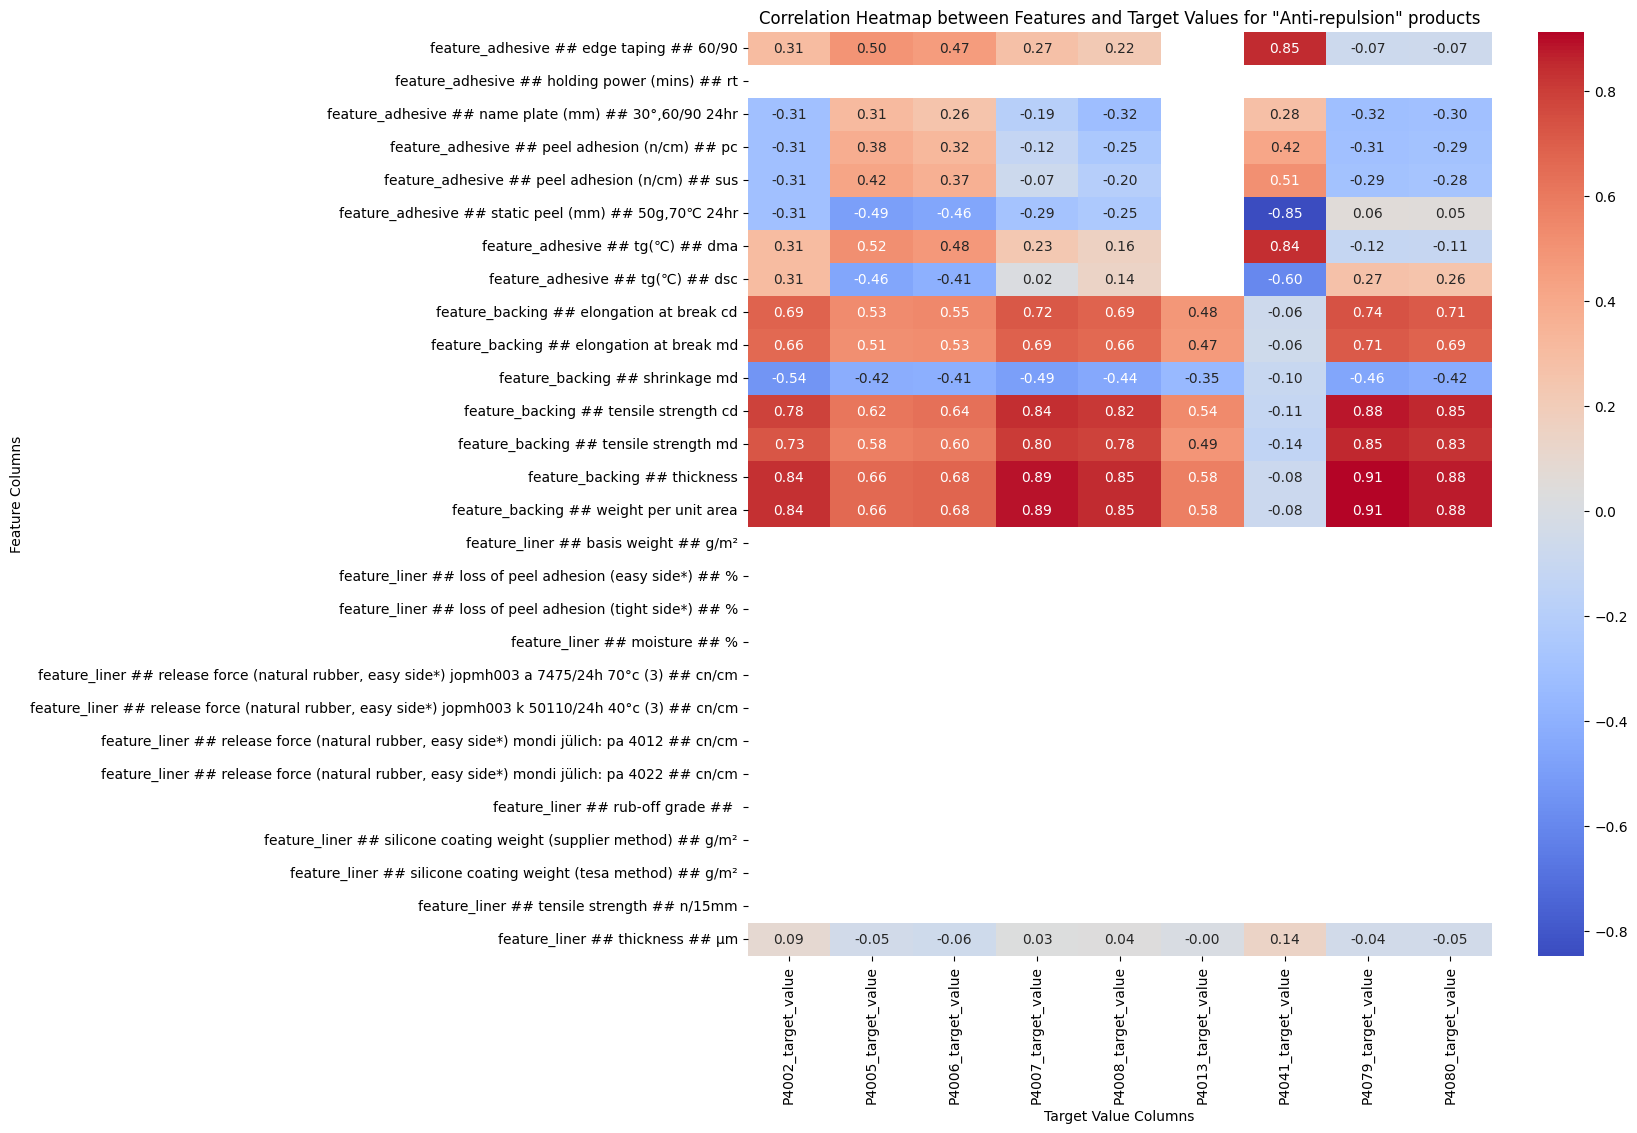

In [300]:
# calculate correlation between each feature in focus_feature_cols and each target in focus_target_cols,
#  save result as dataframe with focus_feature_cols as index and focus_target_cols as columns
df_feature_target_corr = pd.DataFrame(index=focus_feature_cols, columns=focus_target_cols)
for feature_col in focus_feature_cols:
    for target_col in focus_target_cols:
        corr = df_anti_repulsion[[feature_col, target_col]].corr().loc[feature_col, target_col]
        df_feature_target_corr.loc[feature_col, target_col] = corr


# correlation df preview
print(
    "feature-target correlation preview:\n",
    df_feature_target_corr.head().to_string()
)
print('-' * 120)


# draw heatmap using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(df_feature_target_corr.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Features and Target Values for "Anti-repulsion" products')
plt.xlabel('Target Value Columns')
plt.ylabel('Feature Columns')
plt.show()


# corr = NaN means no correlation

In [301]:
df_anti_repulsion[["feature_backing ## thickness", "P4005_target_value"]].head(30)

,feature_backing ## thickness,P4005_target_value
7,NaN,6.3
8,4.5,6.3
9,NaN,7.5
10,4.5,7.5
11,NaN,7.5
12,4.5,7.5
13,12.0,10.3
14,12.0,10.3
15,12.0,10.3
16,12.0,10.3


In [302]:
df_anti_repulsion[["feature_backing ## thickness", "P4005_target_value"]].corr()

,feature_backing ## thickness,P4005_target_value
feature_backing ## thickness,1.000000,0.659374
P4005_target_value,0.659374,1.000000


# General mounting

In [303]:
item_nos = [col.split("_")[0] for col in df_data.columns if col.endswith("_target_value")]
item_nos  = sorted(list(set(item_nos)))
print("item_nos:", item_nos)
print("-" * 120)


# anti 
df_general_mount = df_data[df_data["L2"] == "General mounting"].copy()
print(
    "df general mounting preview:\n", 
    df_general_mount.head(5).to_string()
)

item_nos: ['P4002', 'P4005', 'P4006', 'P4007', 'P4008', 'P4013', 'P4041', 'P4079', 'P4080', 'P4433']
------------------------------------------------------------------------------------------------------------------------
df general mounting preview:
       Product Spec   Adhesive_NART      Liner_NART    Backing_NART              L1                L2    P4080_value  P4080_lb  P4080_ub  P4080_target_value   P4079_value  P4079_lb  P4079_ub  P4079_target_value P4005_value  P4005_lb  P4005_ub  P4005_target_value P4006_value  P4006_lb  P4006_ub  P4006_target_value P4007_value  P4007_lb  P4007_ub  P4007_target_value P4008_value  P4008_lb  P4008_ub  P4008_target_value P4002_value  P4002_lb  P4002_ub  P4002_target_value P4041_value  P4041_lb  P4041_ub  P4041_target_value P4013_value  P4013_lb  P4013_ub  P4013_target_value P4433_value  P4433_lb  P4433_ub  P4433_target_value  feature_adhesive ## acid free ##   feature_adhesive ## edge taping ## 60/90  feature_adhesive ## heat resistance ## 200℃ 

## Target level

In [304]:
# target missing rate
df_target_missing_rates = df_general_mount[[f"{item_no}_target_value" for item_no in item_nos]]\
                            .isnull()\
                            .mean()\
                            .reset_index()\
                            .rename(columns={"index": "item_no", 0: "missing_rate"})


df_target_missing_rates.sort_values("missing_rate")
print(
    "Top 10 target value columns with lowest missing rates:\n",
    df_target_missing_rates.sort_values("missing_rate").head(10).to_string()
)
print("-" * 120)


focus_target_cols = df_target_missing_rates[df_target_missing_rates["missing_rate"] < 0.5]["item_no"].tolist()
print(
    "focus_target_cols:\n", 
    focus_target_cols
)

# convert data type
for col in focus_target_cols:
    df_anti_repulsion[col] = pd.to_numeric(df_anti_repulsion[col], errors='coerce')

print('-' * 120)



Top 10 target value columns with lowest missing rates:
               item_no  missing_rate
0  P4002_target_value           0.0
1  P4005_target_value           0.0
2  P4006_target_value           0.0
3  P4007_target_value           0.0
4  P4008_target_value           0.0
5  P4013_target_value           0.0
6  P4041_target_value           0.0
7  P4079_target_value           0.0
8  P4080_target_value           0.0
9  P4433_target_value           1.0
------------------------------------------------------------------------------------------------------------------------
focus_target_cols:
 ['P4002_target_value', 'P4005_target_value', 'P4006_target_value', 'P4007_target_value', 'P4008_target_value', 'P4013_target_value', 'P4041_target_value', 'P4079_target_value', 'P4080_target_value']
------------------------------------------------------------------------------------------------------------------------


target correlation preview:
     P4002_target_value  P4005_target_value  P4006_target_value  P4007_target_value  P4008_target_value  P4013_target_value  P4041_target_value  P4079_target_value  P4080_target_value
17                50.0                 6.4                 6.6                 8.2                 8.4                 6.5              1000.0                32.3                58.3
18                50.0                 6.4                 6.6                 8.2                 8.4                 6.5              1000.0                32.3                58.3
19                50.0                 6.4                 6.6                 8.2                 8.4                 6.5              1000.0                32.3                58.3
20                50.0                 6.4                 6.6                 8.2                 8.4                 6.5              1000.0                32.3                58.3
21                80.0                 7.3              

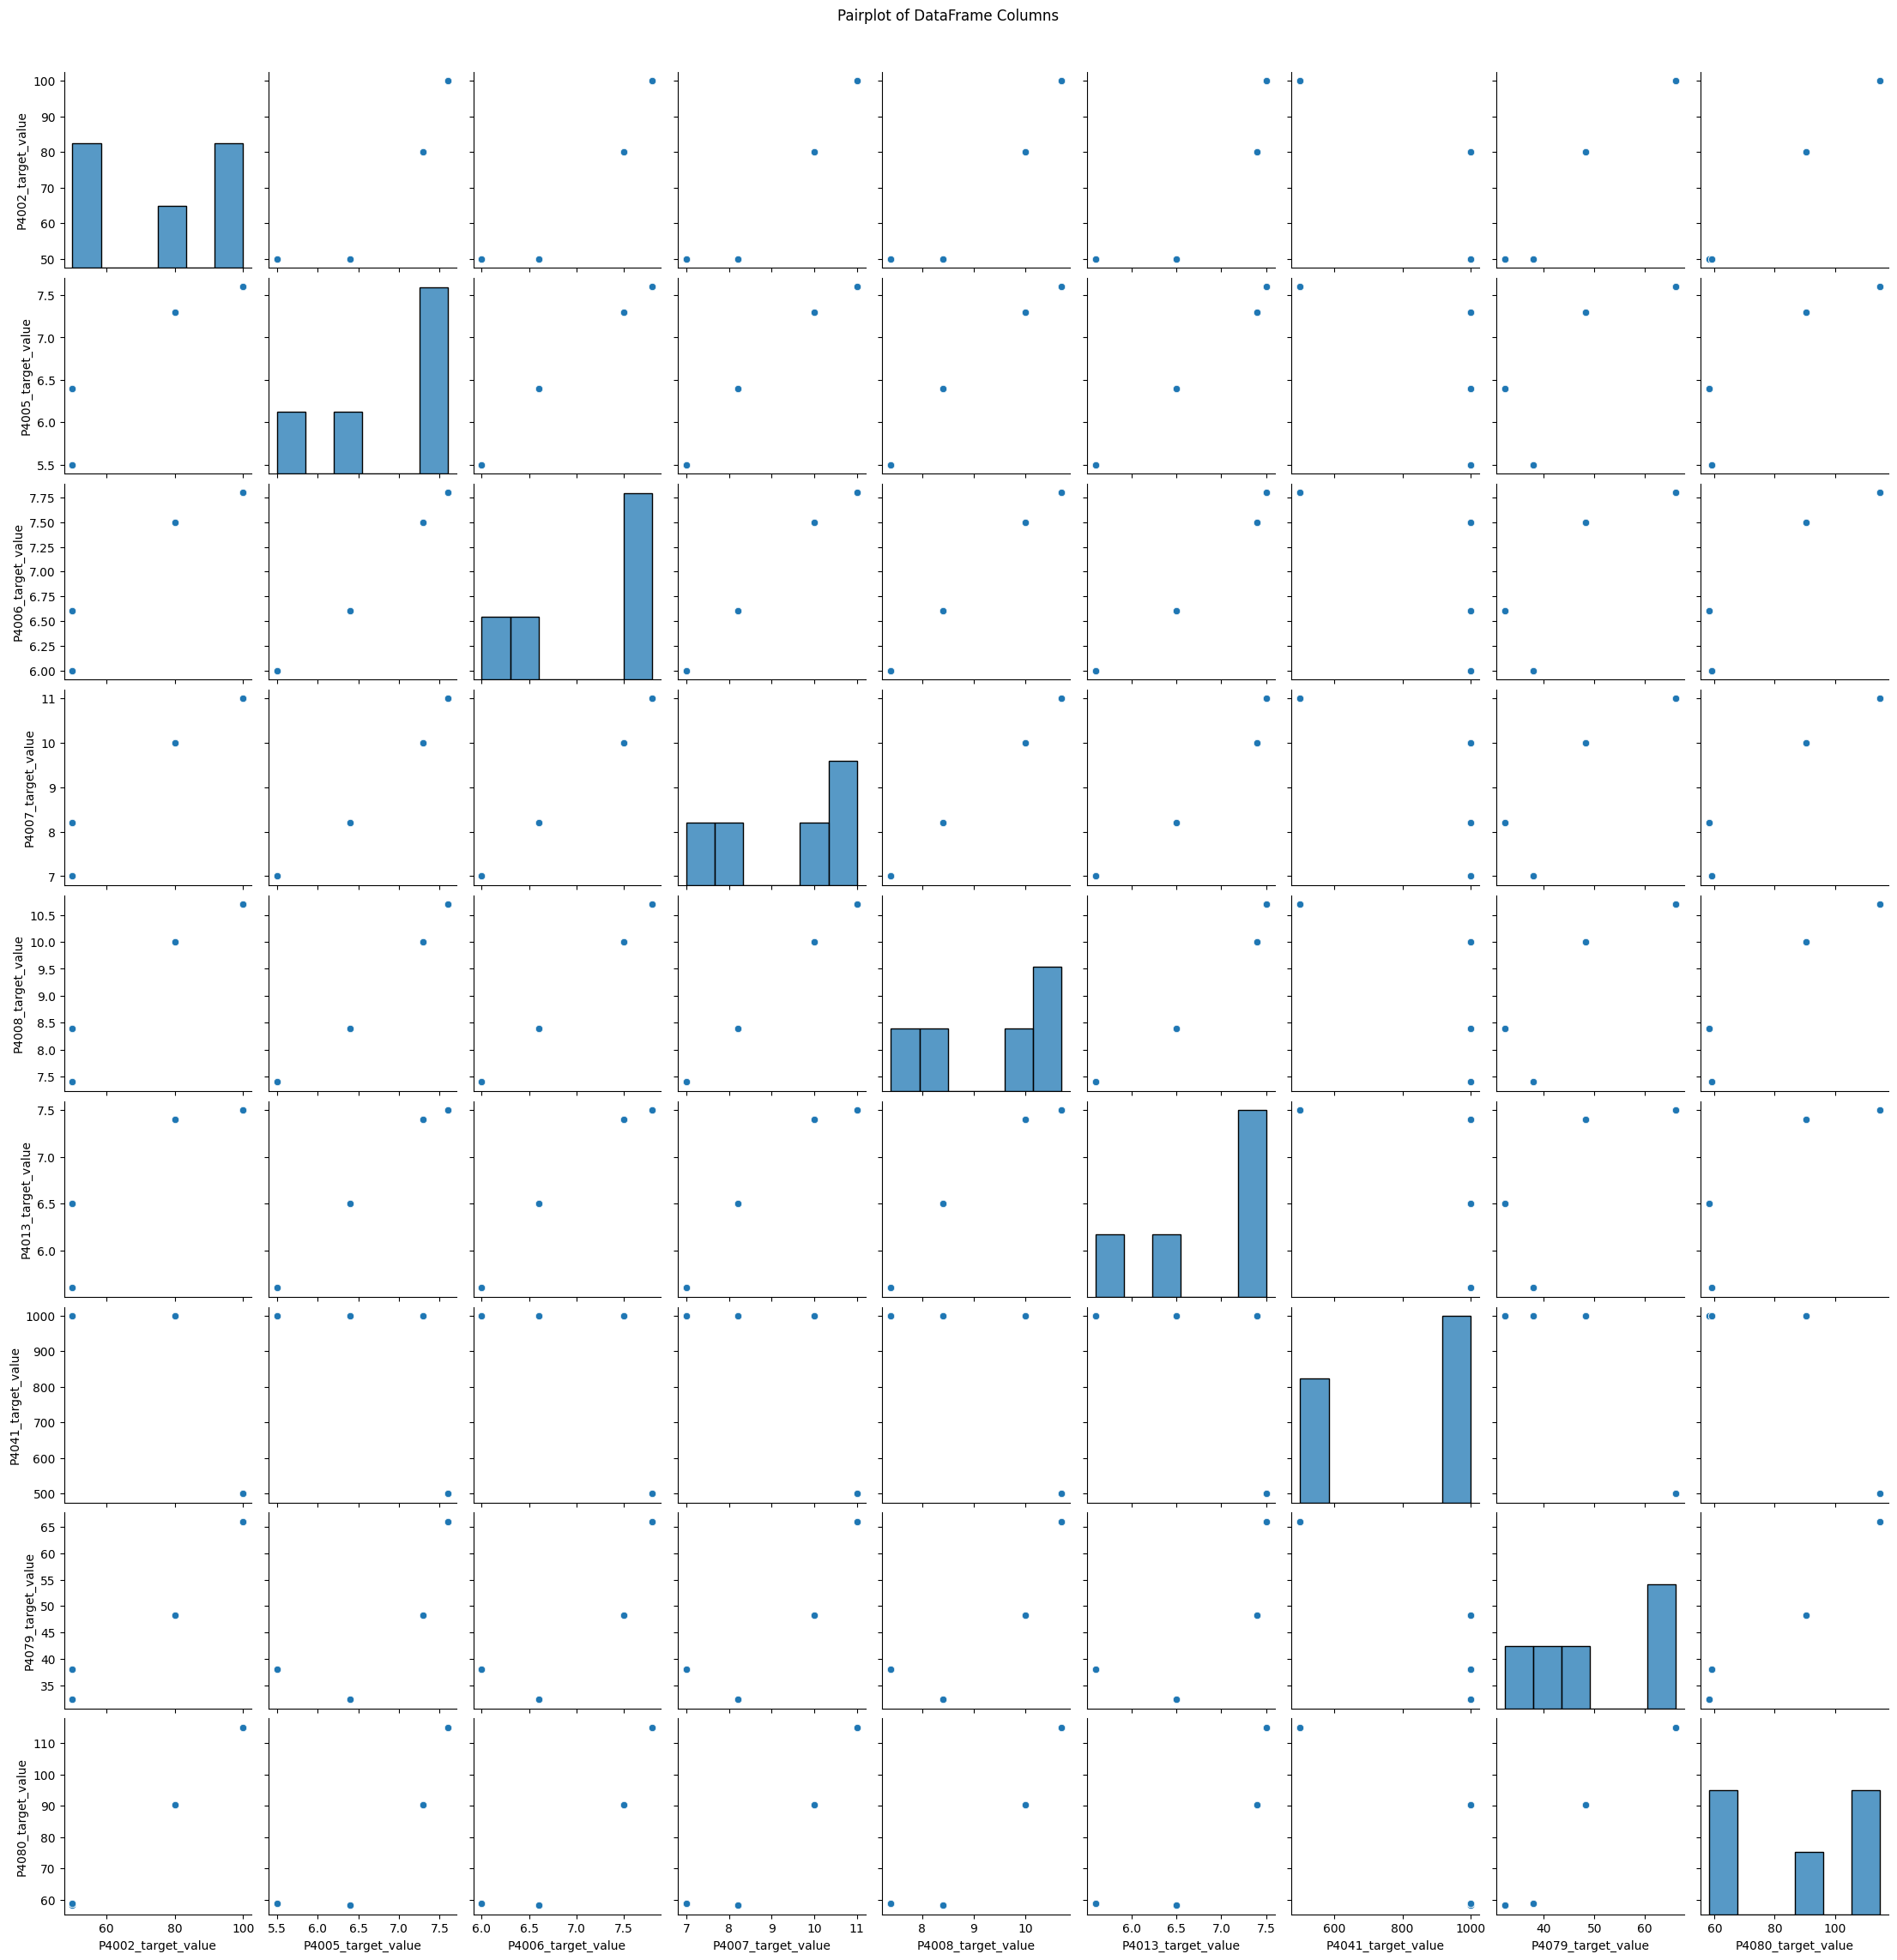

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt


# corr between target value columns
df_target_corr = df_general_mount[focus_target_cols].copy()
print(
    "target correlation preview:\n",
    df_target_corr.head().to_string()
)
print('-' * 120)


# corr between target value columns
# 1. 基础的 pairplot
# Seaborn 会自动识别数值列并绘制它们两两之间的关系图
sns.pairplot(df_target_corr)
plt.suptitle('Pairplot of DataFrame Columns', y=1.02) # y调整标题位置
plt.show()


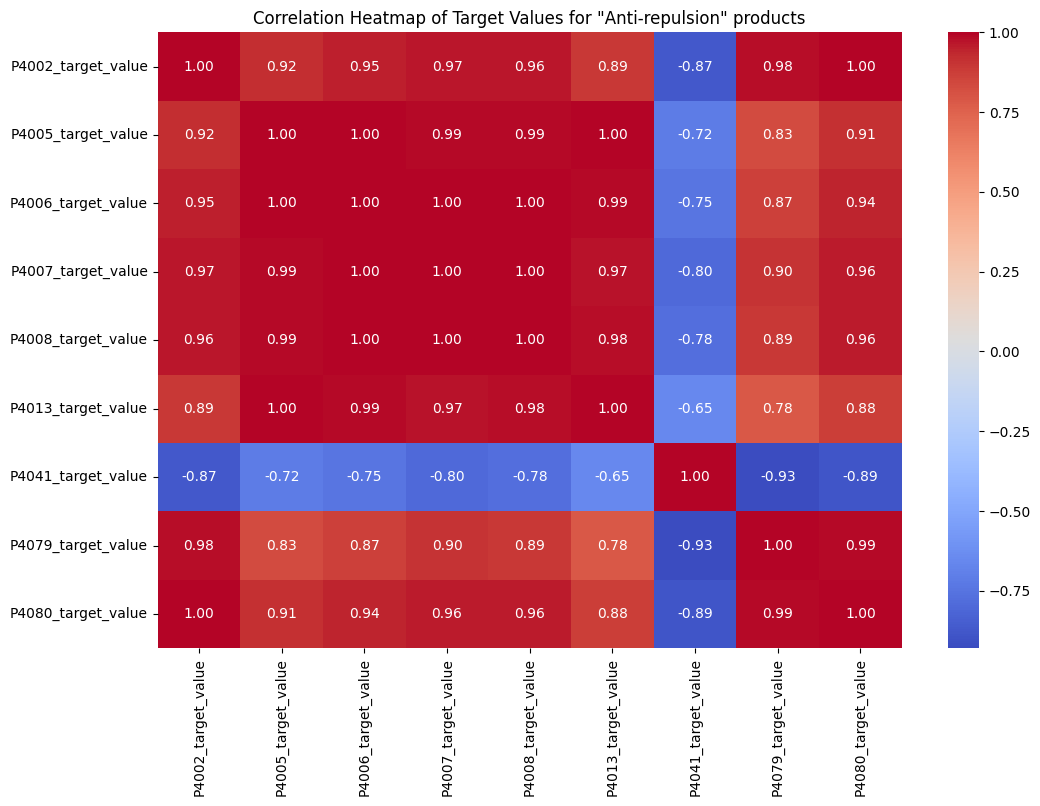

In [306]:
# Calculate the correlation matrix
corr_matrix = df_target_corr.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Target Values for "Anti-repulsion" products')
plt.show()



## Feature level

In [307]:
# calculate missing rate for each feature column
df_feature_missing_rates = []
feature_cols = [col for col in df_general_mount.columns if col.startswith("feature_")]
for col in feature_cols:
    missing_rate = df_general_mount[col].isnull().mean()
    df_feature_missing_rates.append({"feature_col": col, "missing_rate": missing_rate})
df_feature_missing_rates = pd.DataFrame(df_feature_missing_rates)


# filter feature columns with missing rate
focus_feature_cols = df_feature_missing_rates[df_feature_missing_rates["missing_rate"] < 0.5]["feature_col"].tolist()
print(
    "total focus feature cols:", len(focus_feature_cols)
)
print("-" * 120)

# convert data type
for col in focus_feature_cols:
    df_general_mount[col] = pd.to_numeric(df_general_mount[col], errors='coerce')



total focus feature cols: 16
------------------------------------------------------------------------------------------------------------------------


feature-target correlation preview:
                                                       P4002_target_value P4005_target_value P4006_target_value P4007_target_value P4008_target_value P4013_target_value P4041_target_value P4079_target_value P4080_target_value
feature_adhesive ## edge taping ## 60/90                             NaN                NaN                NaN                NaN                NaN                NaN                NaN                NaN                NaN
feature_adhesive ## holding power (mins) ## rt                       NaN                NaN                NaN                NaN                NaN                NaN                NaN                NaN                NaN
feature_adhesive ## name plate (mm) ## 30°,60/90 24hr                NaN                NaN                NaN                NaN                NaN                NaN                NaN                NaN                NaN
feature_adhesive ## peel adhesion (n/cm) ## pc                 

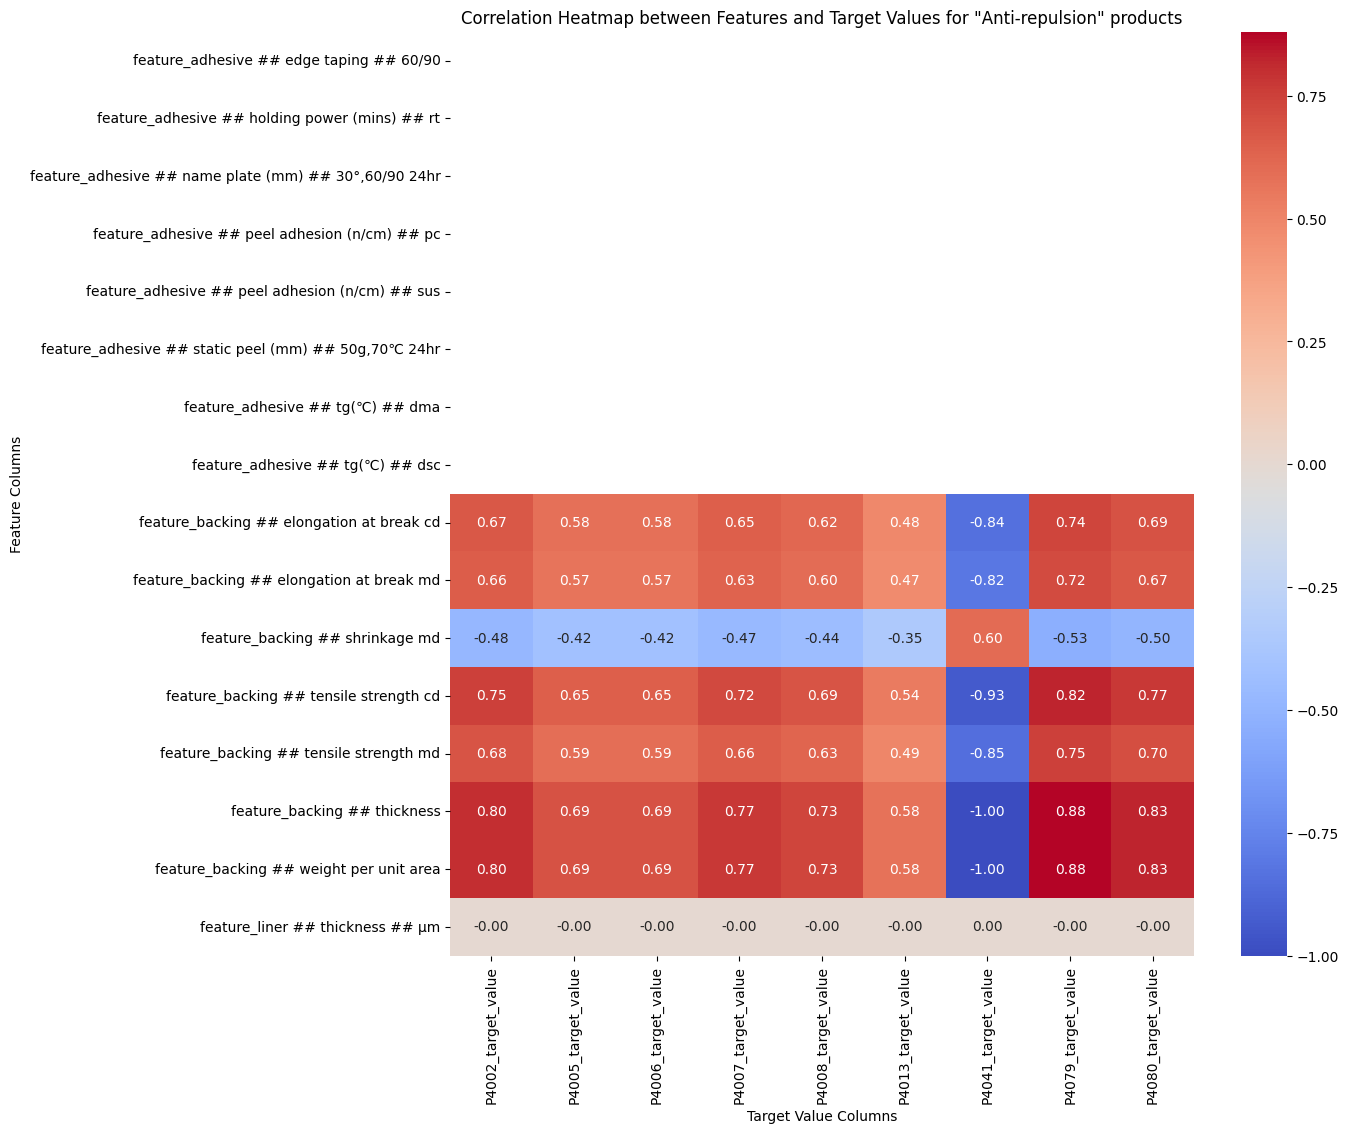

In [308]:
# calculate correlation between each feature in focus_feature_cols and each target in focus_target_cols,
#  save result as dataframe with focus_feature_cols as index and focus_target_cols as columns
df_feature_target_corr = pd.DataFrame(index=focus_feature_cols, columns=focus_target_cols)
for feature_col in focus_feature_cols:
    for target_col in focus_target_cols:
        corr = df_general_mount[[feature_col, target_col]].corr().loc[feature_col, target_col]
        df_feature_target_corr.loc[feature_col, target_col] = corr


# correlation df preview
print(
    "feature-target correlation preview:\n",
    df_feature_target_corr.head().to_string()
)
print('-' * 120)


# draw heatmap using seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(df_feature_target_corr.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Features and Target Values for "Anti-repulsion" products')
plt.xlabel('Target Value Columns')
plt.ylabel('Feature Columns')
plt.show()


# corr = NaN means no correlation

In [309]:
df_item_no[df_item_no["Item No."] == 'P4041']

,Item No.,product count,Item Description
7,P4041,26,"Holding power/steel, open side (10N;RT)"


In [310]:
df_general_mount[["feature_backing ## weight per unit area", "P4041_target_value"]]

,feature_backing ## weight per unit area,P4041_target_value
17,6.3,1000.0
18,6.3,1000.0
19,6.3,1000.0
20,6.3,1000.0
21,6.3,1000.0
22,6.3,1000.0
23,6.3,1000.0
24,6.3,1000.0
25,16.8,500.0
26,16.8,500.0


In [311]:
[c for c in df_general_mount.columns if "unit area" in c]

['feature_backing ## weight per unit area',
 'feature_liner ## weight per unit area ## g/m²']